#1. TRAIN

##0) import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD


##1) load_dataset
---
* LOAD THE EMNIST DATASET
* RESHAPE DATASET TO HAVE ONLY ONE CHANNEL
* ONE HOT ENCODE



In [2]:
def load_dataset():
	(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

	X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
	X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

	Y_train = to_categorical(Y_train)
	Y_test = to_categorical(Y_test)

	return X_train, Y_train, X_test, Y_test

## 2) normalize

---
* CONVERT INTEGERS TO FLOATS
* NORMALIZE


In [3]:
def normalize(train, test):
	train_f = train.astype('float32')
	test_f = test.astype('float32')

	normalized_train = train_f / 255.0
	normalized_test = test_f / 255.0

	return normalized_train, normalized_test

##3) set_model



---


* DEFINE NEURAL NETWORK MODEL

In [4]:
def set_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=(1,1), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((3, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((3, 3)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # ANOTHER OPTIMIZER (ADAM)
    # model.compile(loss="categorical_crossentropy",
    #           optimizer="adam",
    #           metrics=["acc"])
    model.summary()
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

    return model


## 4) diagnostics

---
* SUMMARIZE DIAGNOSTICS

In [5]:
def diagnostics(history):

	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy')
	plt.plot(history.history['acc'], color='blue', label='train')
	plt.plot(history.history['val_acc'], color='orange', label='test')
	plt.show()

##5) performance

---
* SUMMARIZE PERFORMANCE

In [6]:
def performance(scores):
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	plt.boxplot(scores)
	plt.show()

##6) train
---
* LOAD DATASED
* PREPARE IMAGE - TYPE CONVERSE, NORMALIZE
* DEFINE NEURAL NETWORK MODEL
* TRAIN NEURAL NETWORK
* SAVE MODE

In [7]:
def train():
    X_train, Y_train, X_test, Y_test = load_dataset()
    X_train, X_test = normalize(X_train, X_test)
    model = set_model()
    history = model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)
    loss, acc = model.evaluate(X_test, Y_test)
    diagnostics(history)
    print("Accuracy: {0}, Loss: {1}".format(acc, loss))
    model.save('trained_model_2.h5')

11501568/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                         

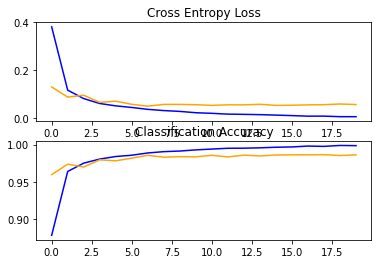

Accuracy: 0.9883999824523926, Loss: 0.04641677066683769
Model saved into trained_model.h5


In [8]:
train()

print("Model saved into trained_model.h5")

#MAIN

##0) import, etc

In [18]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import cv2 as cv
import numpy as np
import sys
import math
import os

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

test_images = list()
test_images.append('test_images/0.jpeg')
test_images.append('test_images/1.jpeg')
test_images.append('test_images/2.jpeg')
test_images.append('test_images/3.jpeg')
test_images.append('test_images/4.jpeg')
test_images.append('test_images/5.jpeg')
test_images.append('test_images/6.jpeg')
test_images.append('test_images/7.jpeg')
test_images.append('test_images/8.jpeg')
test_images.append('test_images/9.jpeg')
test_images.append('test_images/0_t.jpeg')
test_images.append('test_images/9_d.png')
test_images.append('test_images/9_t.jpeg')

wrong = 0
good = 0

##1) find_digit

In [10]:
def find_digit(filename):
    for m in filename:
        if m.isdigit():
            return m

##2) evaluate

In [11]:
wrong = 0
good = 0
def evaluate(digit, filename):
    expected_number = find_digit(filename)
    expected_number = int(expected_number)
    predicted_number = digit[0]

    if expected_number == predicted_number:
        print(bcolors.OKGREEN + "CORRECT. Expected: {0}, Predicted: {1}".format(expected_number, predicted_number) + bcolors.ENDC)
        global good
        good += 1
    else:
        print(bcolors.FAIL + "WRONG. Expected: {0}, Predicted: {1}".format(expected_number, predicted_number) + bcolors.ENDC)
        global wrong
        wrong += 1

##3) test_all

In [12]:
for i in range(len(test_images)):

        img = load_img(test_images[i], color_mode="grayscale", target_size=(28, 28))

        img = img_to_array(img)

        img = img.reshape(1, 28, 28, 1)

        img = img.astype('float32')
        img = img / 255.0

        loaded_model = load_model("trained_model_2.h5")
        predict_value = loaded_model.predict(img)
        digit = predict_value.argmax(axis=-1)
        evaluate(digit, test_images[i])
        #print("Predicted number: {0}, Num in file: {1}".format(digit, test_images[i]))

WRONG. Expected: 0, Predicted: 9
WRONG. Expected: 1, Predicted: 7
CORRECT. Expected: 2, Predicted: 2
CORRECT. Expected: 3, Predicted: 3
WRONG. Expected: 4, Predicted: 6
CORRECT. Expected: 5, Predicted: 5
CORRECT. Expected: 6, Predicted: 6
CORRECT. Expected: 7, Predicted: 7
CORRECT. Expected: 8, Predicted: 8
WRONG. Expected: 9, Predicted: 3
CORRECT. Expected: 0, Predicted: 0
WRONG. Expected: 9, Predicted: 0
CORRECT. Expected: 9, Predicted: 9


##4) test_single

In [19]:
def test_single():
    filename = 'test_images/0_t.jpeg'
    img = load_img(filename, color_mode="grayscale", target_size=(28, 28))
    plt.imshow(img)
    plt.show()

    img = img_to_array(img)
    img = img.reshape(1, 28, 28, 1)
    img = img.astype('float32')
    img = img / 255.0
    loaded_model = load_model("trained_model_2.h5")
    predict_value = loaded_model.predict(img)
    digit = predict_value.argmax(axis=-1)
    # print("Predicted number: {0}".format(digit))
    evaluate(digit, filename)

In [16]:
if sys.argv[1] == 'all':
    test_all()
elif sys.argv[1] == 'single':
    test_single()
else:
    print("Wrong parameter")
    exit(42)

print(f'Number of images: {len(test_images)}')
print("Right: {0}, Wrong: {1}".format(good, wrong))
Accuracy = good/len(test_images)*100
print(f'Accuracy : {round(Accuracy,2)}')

Wrong parameter
Number of images: 13
Right: 8, Wrong: 5
Accuracy : 61.54


##Changes in perception according to images

In [20]:
for currentdir, dirs, files in os.walk(r"/content/PRETTY"):
 
    for file in files :
    
        # print(currentdir+r"\\"+file)

        img_path = currentdir+'/'+file
        print(img_path)
        if img_path == '/content/Test_IMG/.DS_Store':
          print("afsdasfd")
        else :
          print()
          img = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE) #경로와 이름 잘 맞추기
          cv2_imshow(img)
          img = cv2.resize(255-img, (28, 28))
          img.shape

          test_num = img.flatten()/255.0
          test_num = test_num.reshape((-1, 28, 28, 1))
          test_num.shape

          # print('The answer is ', model.predict_classes(test_num))

          print('The answer is ', np.argmax(model.predict(test_num), axis=-1))